In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import glob
import data_utils.data_utils_celeba_pytorch as data_utils
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import numpy as np
import pandas as pd
import os

In [3]:
pwd

'/Users/aleksanderpratt/OneDrive - Danmarks Tekniske Universitet/9. Semester/DeepLearning/Project/AlgorithmicFairness'

In [13]:
# Root directory for dataset
dataroot = '/Users/aleksanderpratt/OneDrive - Danmarks Tekniske Universitet/9. Semester/DeepLearning/Project/AlgorithmicFairness'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

In [15]:
attributes = pd.read_csv(dataroot+'/Data/list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv(dataroot+'/Data/list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

In [16]:
train = matched[matched['partition']==0]
valid = matched[matched['partition']==1]
test = matched[matched['partition']==2]
train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')

In [20]:
pwd

'/Users/aleksanderpratt/OneDrive - Danmarks Tekniske Universitet/9. Semester/DeepLearning/Project/AlgorithmicFairness'

In [58]:
IMAGE_SHAPE = [73,60,3]
# Paths to data
TRAIN_PATH =  dataroot + "/train.csv" 
VALID_PATH = dataroot + "/valid.csv" 
TEST_PATH = dataroot + "/test.csv" 
IMAGE_PATHS = "/Users/aleksanderpratt/OneDrive - Danmarks Tekniske Universitet/9. Semester/DeepLearning/Project/CelebFaces/img_align_celeba/"
TARGET_COL = 'Big_Nose'
NUM_CLASSES = 2

# train holds both X (input) and t (target/truth)
data_train = data_utils.CelebADataset(TRAIN_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [59]:
dataloader = DataLoader(data_valid, batch_size=128,shuffle=True, num_workers=6)

In [60]:
160000/128/4/60

5.208333333333333

In [61]:
20000/128/4/60

0.6510416666666666

In [62]:
from tqdm import tqdm_notebook
for i_batch, sample_batched in tqdm_notebook(enumerate(dataloader)):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['target'].size())

    # observe 4th batch and stop.
    if i_batch == 10:
        print('done')
        break

0 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
1 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
2 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
3 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
4 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
5 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
6 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
7 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
8 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
9 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
10 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
done


In [63]:
sample_batched['attributes'][0]

tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1.], dtype=torch.float64)

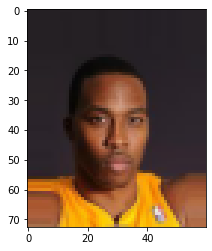

In [64]:
plt.imshow(np.transpose(vutils.make_grid(sample_batched['image'][5], padding=2,normalize=True).cpu(),(1,2,0)))

In [65]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [66]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [67]:
height, width, channels = IMAGE_SHAPE

conv_out_channels =  16 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
 


conv1_h = int(height - kernel_size + 2 * conv_pad / conv_stride + 1)
conv1_w = int(width - kernel_size + 2 * conv_pad / conv_stride + 1)

# Keep track of features to output layer
features_cat_size = int(conv_out_channels * conv1_h * conv1_w)\

# <-- Number of features concatenated before output layer
  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)

             
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        #x_img = x_img.permute(0,3,1,2)
        features_img = relu(self.conv_1(x_img))
        
        features_img = features_img.view(-1, features_cat_size)

        ## Output layer where all features are in use ##
        
        out['out'] = self.l_out(features_img)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (l_out): Linear(in_features=61824, out_features=2, bias=False)
)


In [68]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [69]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
image = randnorm(_img_shape)
image = image.transpose(0,3, 1, 2)
_x_image = get_variable(Variable(torch.from_numpy(image)))

# test the forward pass
output = net(x_img=_x_image)
output['out'].shape

torch.Size([128, 2])

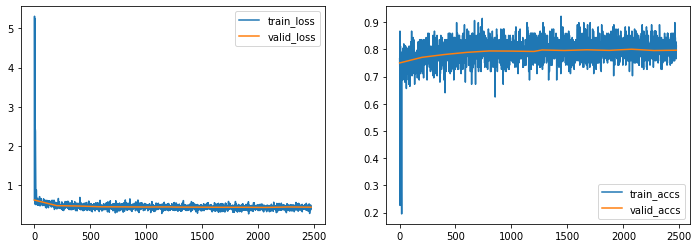

In [70]:
# Setup settings for training 
batch_size=128
max_iter = 200
log_every = 100
eval_every = 200
num_epochs = 2

# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen_train = DataLoader(data_train, batch_size, shuffle=True, num_workers=6)
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)

# Train network
j=0
net.train()
for epoch in range(num_epochs):
    for i, batch_train in enumerate(batch_gen_train):
        j+=1
        if i % eval_every == 0:
            

            # Do the validaiton
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            with torch.no_grad(): 
                for batch_valid in batch_gen_valid:
                    num = len(batch_valid['target'])
                    output = net(**get_input(batch_valid))
                    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                    val_losses += criterion(output['out'], labels_argmax) * num
                    val_accs += accuracy(output['out'], labels_argmax) * num
                    val_lengths += num

                # Divide by the total accumulated batch sizes
                val_losses /= val_lengths
                val_accs /= val_lengths
                valid_loss.append(get_numpy(val_losses))
                valid_accs.append(get_numpy(val_accs))
                valid_iter.append(j)
        #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
                net.train()

        # Train network
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        train_iter.append(j)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Log i figure
        if i % log_every == 0:
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            clear_output(wait=True)
            #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))

In [71]:
print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
print("Valid, it: {} loss: {:.2f} accs: {:.4f}".format(i, valid_loss[-1], valid_accs[-1]))

Train, it: 1271 loss: 0.45 accs: 0.79
Valid, it: 1271 loss: 0.44 accs: 0.7971


In [72]:
net.eval()
val_male_losses,val_male_accs,val_male_lengths,val_female_losses,val_female_accs,val_female_lengths = 0, 0, 0, 0, 0, 0

with torch.no_grad(): 
    for batch_valid in batch_gen_valid:
        num = len(batch_valid)
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]

        gender = batch_valid['attributes'][:,20]
        male = np.where(gender==1)
        female = np.where(gender==0)

        val_male_losses += criterion(output['out'][male], labels_argmax[male]) * len(male[0]) 
        val_male_accs += accuracy(output['out'][male], labels_argmax[male]) * len(male[0]) 
        val_male_lengths += len(male[0])
        val_female_losses += criterion(output['out'][female], labels_argmax[female]) * len(female[0]) 
        val_female_accs += accuracy(output['out'][female], labels_argmax[female]) * len(female[0]) 
        val_female_lengths += len(female[0])

# Divide by the total accumulated batch sizes
val_male_losses /= val_male_lengths
val_male_accs /= val_male_lengths

val_female_losses /= val_female_lengths
val_female_accs /= val_female_lengths

print("Valid Male, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_male_losses, val_male_accs))
print("Valid Female, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_female_losses, val_female_accs))

Valid Male, it: 1271 loss: 0.47 accs: 0.7746

Valid Female, it: 1271 loss: 0.40 accs: 0.8204



In [73]:
matched.iloc[:,0:-1].drop('Smiling',axis=1).columns[20]

'Male'

In [74]:
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(images_batch[i].numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        print(bias[i])
        print(output['out'][i])

<Figure size 432x288 with 0 Axes>

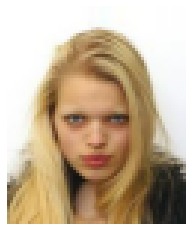

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.5063, -1.5371])


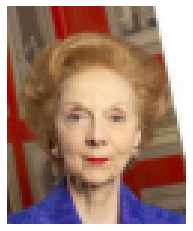

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.8590, -0.8988])


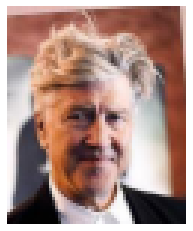

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-0.3691,  0.3204])


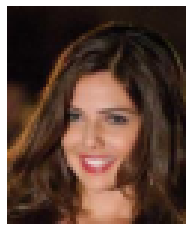

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 1.2172, -1.2323])


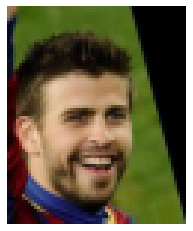

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 0.2230, -0.2628])


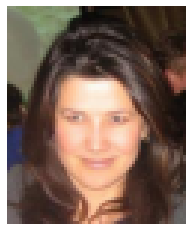

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.4306, -0.4375])


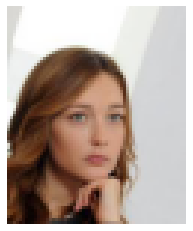

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.0685, -1.1082])


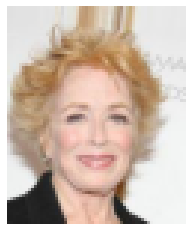

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 1.0557, -1.0602])


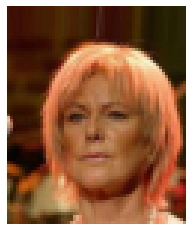

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.5540, -1.5598])


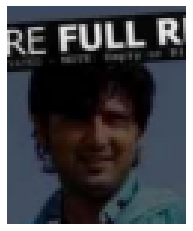

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.0648, -0.1201])


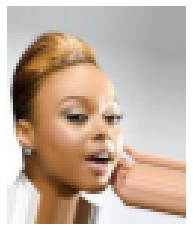

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 1.3916, -1.3825])


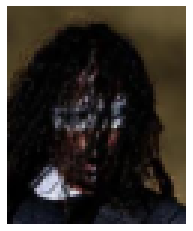

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.4942, -0.5075])


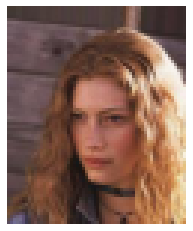

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.1604, -1.1770])


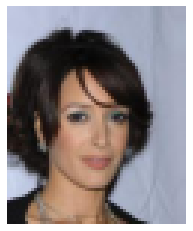

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.4125, -1.4210])


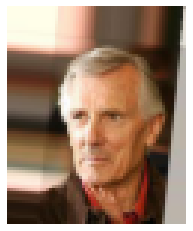

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.9937, -1.0558])


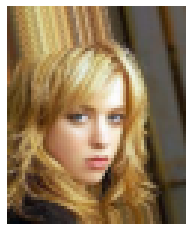

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.8557, -1.8827])


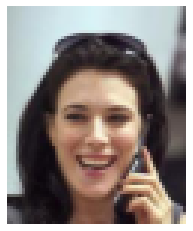

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 0.8710, -0.8944])


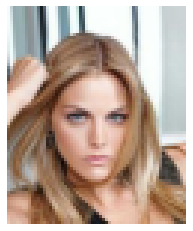

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.4610, -1.5147])


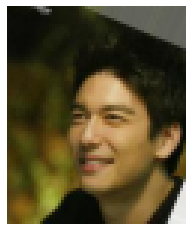

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 0.6907, -0.6994])


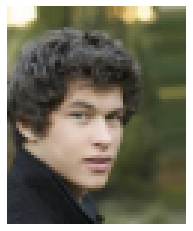

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.6767, -0.7144])


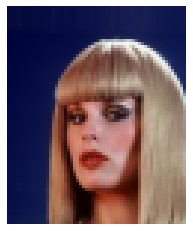

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 1.5264, -1.5388])


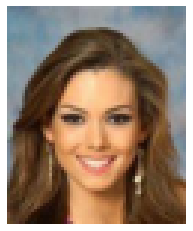

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 1.3745, -1.4347])


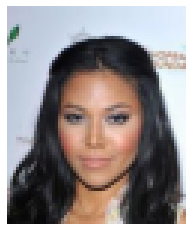

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.8957, -0.8800])


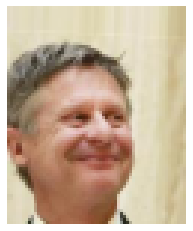

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.1584, -0.2148])


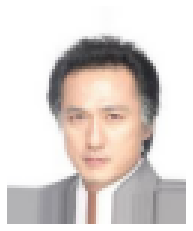

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 0.7330, -0.7448])


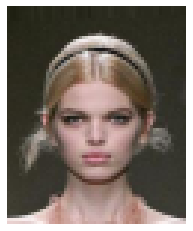

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.0330, -1.0446])


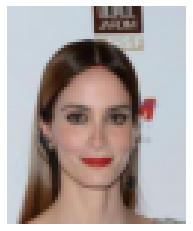

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.6754, -1.7069])


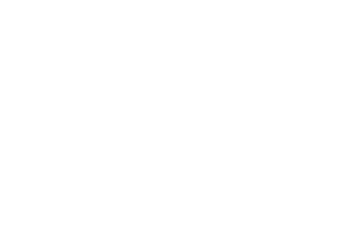

In [75]:
plt.figure()
show_batch(batch_valid,20)
plt.axis('off')
plt.ioff()
plt.show()

In [76]:
def conv_dim(dim_size):
    return int(dim_size - kernel_size + 2 * conv_pad / conv_stride + 1)
    
conv_dim(2)

-2

In [77]:
height, width, channels = IMAGE_SHAPE

conv_out_channels =  16 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
 
def conv_dim(dim_size):
    return int(dim_size - kernel_size + 2 * conv_pad / conv_stride + 1)

conv1_h = conv_dim(height)//2
conv1_w = conv_dim(width)//2

# Keep track of features to output layer
features_cat_size = int(conv_out_channels * conv1_h * conv1_w)

conv2_h = conv_dim(conv1_h)//2
conv2_w = conv_dim(conv1_w)//2
        
features_cat_size2 = int(conv_out_channels*2 * conv2_h * conv2_w)

# <-- Number of features concatenated before output layer
  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        
        self.conv_2 = Conv2d(in_channels=conv_out_channels,
                             out_channels=conv_out_channels*2,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.dropout = Dropout2d(p=0.5)
        
        self.batch1 = BatchNorm2d(conv_out_channels)
        self.batch2 = BatchNorm2d(conv_out_channels*2)

             
        self.l_out = Linear(in_features=features_cat_size2,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        features_img = self.pool(tanh(self.conv_1(x_img)))
        features_img = self.batch1(features_img)
        features_img = self.dropout(features_img)
        features_img = self.pool(tanh(self.conv_2(features_img)))
        features_img = self.batch2(features_img)
        
        features_img = features_img.view(-1, features_cat_size2)

        ## Output layer where all features are in use ##
        
        out['out'] = self.l_out(features_img)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=5760, out_features=2, bias=False)
)


In [78]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

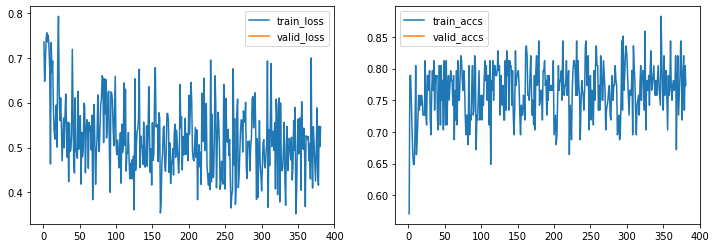

In [79]:
# Setup settings for training 
batch_size=128
max_iter = 199
log_every = 20
eval_every = 200
num_epochs = 2

# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen_train = DataLoader(data_train, batch_size, shuffle=True, num_workers=6)
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)

# Train network
j=0
net.train()
for epoch in range(num_epochs):
    for i, batch_train in enumerate(batch_gen_train):
        j+=1
        if i % eval_every == -1:
            

            # Do the validaiton
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            with torch.no_grad(): 
                for batch_valid in batch_gen_valid:
                    num = len(batch_valid['target'])
                    output = net(**get_input(batch_valid))
                    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                    val_losses += criterion(output['out'], labels_argmax) * num
                    val_accs += accuracy(output['out'], labels_argmax) * num
                    val_lengths += num

                # Divide by the total accumulated batch sizes
                val_losses /= val_lengths
                val_accs /= val_lengths
                valid_loss.append(get_numpy(val_losses))
                valid_accs.append(get_numpy(val_accs))
                valid_iter.append(j)
        #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
                net.train()

        # Train network
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        train_iter.append(j)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Log i figure
        if i % log_every == 0:
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            clear_output(wait=True)
            #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
            
        if max_iter == i:
            break

In [80]:
net.eval()
val_losses, val_accs, val_lengths = 0, 0, 0
with torch.no_grad(): 
    for batch_valid in batch_gen_valid:
        num = len(batch_valid['target'])
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        val_losses += criterion(output['out'], labels_argmax) * num
        val_accs += accuracy(output['out'], labels_argmax) * num
        val_lengths += num

    # Divide by the total accumulated batch sizes
    val_losses /= val_lengths
    val_accs /= val_lengths
print('loss:',val_losses)
print('acc:',val_accs)

loss: tensor(0.5001)
acc: tensor(0.7718)


In [81]:
net.eval()
val_male_losses,val_male_accs,val_male_lengths,val_female_losses,val_female_accs,val_female_lengths = 0, 0, 0, 0, 0, 0

with torch.no_grad(): 
    for batch_valid in batch_gen_valid:
        num = len(batch_valid)
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]

        gender = batch_valid['attributes'][:,20]
        male = np.where(gender==1)
        female = np.where(gender==0)

        val_male_losses += criterion(output['out'][male], labels_argmax[male]) * len(male[0]) 
        val_male_accs += accuracy(output['out'][male], labels_argmax[male]) * len(male[0]) 
        val_male_lengths += len(male[0])
        val_female_losses += criterion(output['out'][female], labels_argmax[female]) * len(female[0]) 
        val_female_accs += accuracy(output['out'][female], labels_argmax[female]) * len(female[0]) 
        val_female_lengths += len(female[0])

# Divide by the total accumulated batch sizes
val_male_losses /= val_male_lengths
val_male_accs /= val_male_lengths

val_female_losses /= val_female_lengths
val_female_accs /= val_female_lengths

print("Valid Male, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_male_losses, val_male_accs))
print("Valid Female, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_female_losses, val_female_accs))

Valid Male, it: 199 loss: 0.53 accs: 0.7574

Valid Female, it: 199 loss: 0.47 accs: 0.7851



In [82]:
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['val_1_loss','val_1_acc','val_0_loss','val_0_acc'])

In [86]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [87]:
net.eval()
for att in range(4,len(attributes)):
    print(attributes[att])
    val_1_losses,val_1_accs,val_1_lengths,val_0_losses,val_0_accs,val_0_lengths = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for batch_valid in batch_gen_valid:
            num = len(batch_valid)
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]

            att_ = batch_valid['attributes'][:,att]
            att_1 = np.where(att_==1)
            att_0 = np.where(att_==0)
            
            if len(att_1[0]) > 0:
                val_1_losses += criterion(output['out'][att_1], labels_argmax[att_1]) * len(att_1[0]) 
                val_1_accs += accuracy(output['out'][att_1], labels_argmax[att_1]) * len(att_1[0])
                val_1_lengths += len(att_1[0])
            if len(att_0[0]) > 0:
                val_0_losses += criterion(output['out'][att_0], labels_argmax[att_0]) * len(att_0[0]) 
                val_0_accs += accuracy(output['out'][att_0], labels_argmax[att_0]) * len(att_0[0]) 
                val_0_lengths += len(att_0[0])
            
    TP, FP, TN, FN = perf_measure(labels_argmax[att_0], output['out'][att_0])
    # Divide by the total accumulated batch sizes
    val_1_losses /= val_1_lengths
    val_1_accs /= val_1_lengths

    val_0_losses /= val_0_lengths
    val_0_accs /= val_0_lengths
    
    df_att.iloc[att]['val_1_loss'] = val_1_losses.item()
    df_att.iloc[att]['val_1_acc'] = val_1_accs.item()
    df_att.iloc[att]['val_0_loss'] = val_0_losses.item()
    df_att.iloc[att]['val_0_acc'] = val_0_accs.item()

Bald


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'other'

In [84]:
df_att

,val_1_loss,val_1_acc,val_0_loss,val_0_acc
5_o_Clock_Shadow,NaN,NaN,NaN,NaN
Arched_Eyebrows,NaN,NaN,NaN,NaN
Attractive,NaN,NaN,NaN,NaN
Bags_Under_Eyes,NaN,NaN,NaN,NaN
Bald,0.561739,0.737226,0.498771,0.772512
Bangs,0.438004,0.81578,0.510747,0.764217
Big_Lips,0.436622,0.815703,0.511555,0.763835
Big_Nose,0.604675,0.6986,0.472505,0.79107
Black_Hair,0.282654,0.909359,0.539598,0.746773
Blond_Hair,0.514138,0.742553,0.499375,0.773234
